## Hydra for map-space datacubes

Phil Bull, _2022-11-17_

In [1]:
import numpy as np
import pylab as plt
import scipy.linalg
from scipy.sparse.linalg import cg, gmres, LinearOperator
import time

In [2]:
np.random.seed(10)

## Generate test data
This is based on a simple Gaussian foreground model and Gaussian random signal field.

In [3]:
x = np.linspace(-10., 10., 100) # degrees
y = np.linspace(-10., 10., 104) # degrees
nu = np.linspace(700., 950., 64) # MHz

nu_ref = 1000. # MHz

### 21cm signal

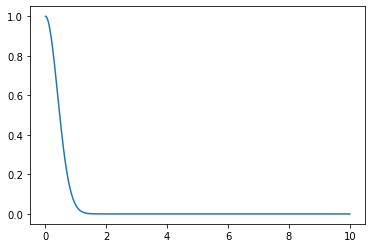

In [4]:
# Basic 21cm signal realisation

# Simple power spectrum model
sigma_pk = 0.4
theory_pspec = lambda k: np.exp(-0.5 * (k / sigma_pk)**2.)

# Plot power spectrum model
plt.subplot(111)
kk = np.logspace(-3., 1., 200)
plt.plot(kk, theory_pspec(kk))

In [5]:
# Unit Gaussian random map
s = np.random.randn(x.size, y.size, nu.size)
s_fft = np.fft.fftn(s)
print(s.shape, s_fft.shape)

# Fourier modes
_kx = np.fft.fftfreq(x.size, d=x[1]-x[0])
_ky = np.fft.fftfreq(y.size, d=y[1]-y[0])
_kz = np.fft.fftfreq(nu.size, d=nu[1]-nu[0])
kx, ky, kz = np.meshgrid(_kx, _ky, _kz, indexing='ij')
k = np.sqrt(kx**2. + ky**2. + kz**2.)

# Power spectrum in each cell
s = np.fft.ifftn(s_fft * np.sqrt(theory_pspec(k))).real

(100, 104, 64) (100, 104, 64)


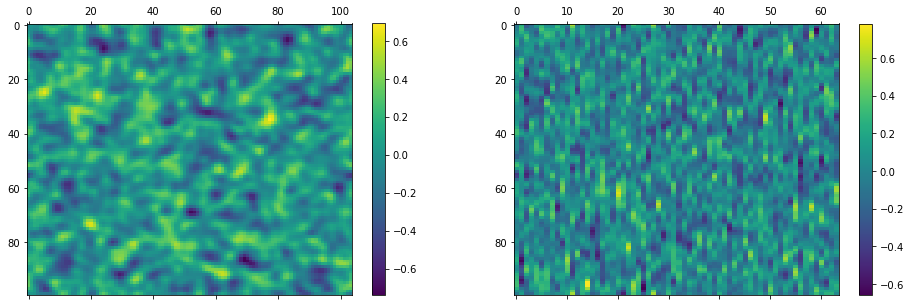

In [6]:
# Plot slices
plt.subplot(121)
plt.matshow(s[:,:,0], aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(122)
plt.matshow(s[:,0,:], aspect='auto', fignum=False)
plt.colorbar()

plt.gcf().set_size_inches((16., 5.))

### Foreground simulation

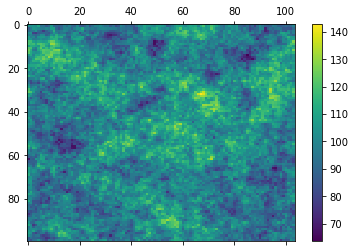

In [7]:
# Unit Gaussian random map
fg_amp = np.random.randn(x.size, y.size)
fg_amp_fft = np.fft.fftn(fg_amp)

kx2d, ky2d = np.meshgrid(_kx, _ky, indexing='ij')
k2d = np.sqrt(kx2d**2. + ky2d**2.)

# Power-law amplitude FG model
theory_pspec_fg = lambda k: (k + 1e-5)**-2.
fg_amp = np.fft.ifftn(fg_amp_fft * np.sqrt(theory_pspec_fg(k2d))).real
fg_amp -= np.mean(fg_amp)
fg_amp = 10.*fg_amp + 100.

# Plot map
plt.subplot(111)
plt.matshow(fg_amp, aspect='auto', fignum=False)
plt.colorbar()

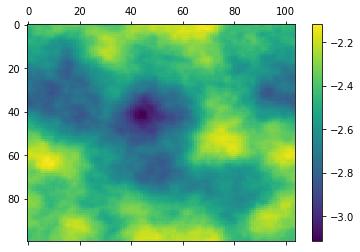

In [8]:
# Unit Gaussian random map
fg_beta = np.random.randn(x.size, y.size)
fg_beta_fft = np.fft.fftn(fg_beta)

# Power-law amplitude FG model
theory_pspec_beta = lambda k: (k/1e-2 + 1e-5)**-4.
fg_beta = np.fft.ifftn(fg_beta_fft * np.sqrt(theory_pspec_beta(k2d))).real
fg_beta -= np.mean(fg_beta)
fg_beta /= (fg_beta.max() - fg_beta.min())
fg_beta = -2.5 + fg_beta

# Plot map
plt.subplot(111)
plt.matshow(fg_beta, aspect='auto', fignum=False)
plt.colorbar()

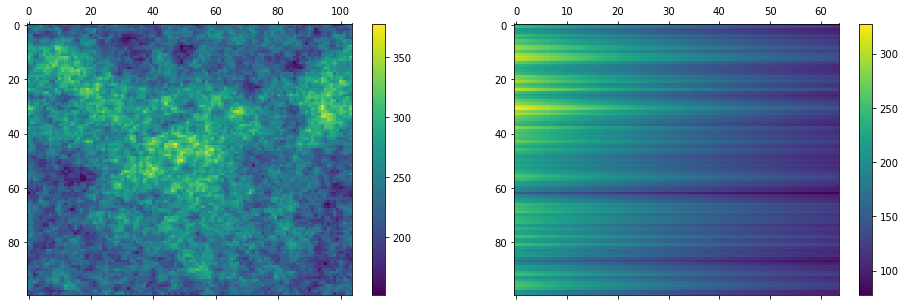

In [9]:
# Combine to make foreground data cube
fg = fg_amp[:,:,np.newaxis] * (nu / nu_ref)[np.newaxis,np.newaxis,:]**fg_beta[:,:,np.newaxis]

# Plot slices
plt.subplot(121)
plt.matshow(fg[:,:,0], aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(122)
plt.matshow(fg[:,0,:], aspect='auto', fignum=False)
plt.colorbar()

plt.gcf().set_size_inches((16., 5.))

### Noise

In [10]:
t_obs = 10. # sec
dnu = nu[1] - nu[0] # MHz
noise_var = fg**2. / (t_obs * dnu*1e6)

In [11]:
np.sqrt(noise_var.min()), np.sqrt(noise_var.max())

(0.011445306377481337, 0.060043118878800095)

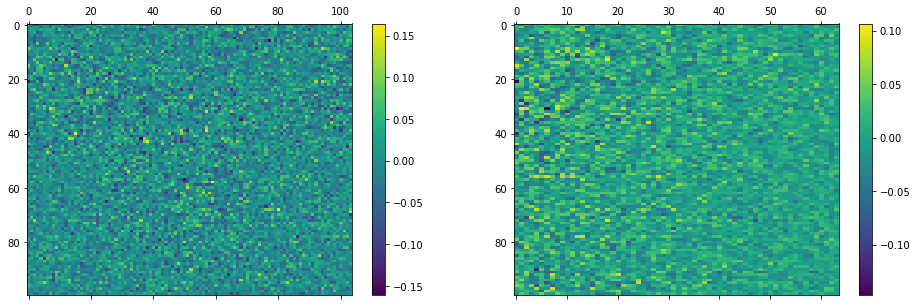

In [12]:
# Generate noise
n = np.random.randn(x.size, y.size, nu.size) * np.sqrt(noise_var)

# Plot slices
plt.subplot(121)
plt.matshow(n[:,:,0], aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(122)
plt.matshow(n[:,0,:], aspect='auto', fignum=False)
plt.colorbar()

plt.gcf().set_size_inches((16., 5.))

### Combined data

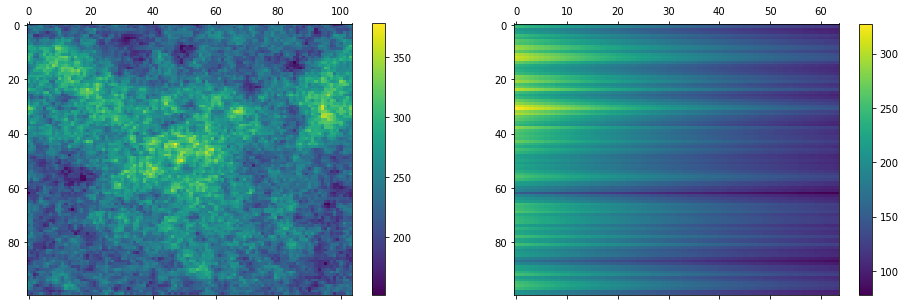

In [13]:
# Ignore beam for now!
d = fg + s + n

# Plot slices
plt.subplot(121)
plt.matshow(d[:,:,0], aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(122)
plt.matshow(d[:,0,:], aspect='auto', fignum=False)
plt.colorbar()

plt.gcf().set_size_inches((16., 5.))

# Gaussian Constrained Realisation equations

Solve equation:
$\left [ 1 + S^\frac{1}{2} A^T N^{-1} A S^\frac{1}{2} \right ] x = S^\frac{1}{2} A^T \left ( N^{-1} d + N^{-\frac{1}{2}} \omega_n \right ) + \omega_s$

In [14]:
def unpack_solution(x, fft_shape, sqrtS=None):
    """
    Reorder solution vector and perform inverse FFT on it. 
    """
    # Don't multiply by sqrt of prior covariance if not specified
    if sqrtS is None:
        sqrtS = 1.
        
    # Combine real and imaginary, and reshape into 2D map and inv. FFT
    xx = 1.0 * x[:x.size//2].reshape(fft_shape) \
       + 1.j * x[x.size//2:].reshape(fft_shape)
    x_map = np.fft.irfft2(sqrtS * xx)
    return x_map


def apply_operator(x, beta, dimensionless_freq, inv_noise_var, sqrtS):
    """
    Apply operator for FG amplitudes (in Fourier space).
    """
    fft_shape = sqrtS.shape
    
    # Combine real and imaginary, and reshape into 2D map and inv. FFT
    xx = 1.0 * x[:x.size//2].reshape(fft_shape) \
       + 1.j * x[x.size//2:].reshape(fft_shape)
    x_map = np.fft.irfft2(sqrtS * xx) # multiply by S^1/2 and inverse FFT
    
    # Multiply by spectral function (squared because N^-1 is diagonal and freq. factor is real)
    # Last axis is the frequency axis
    y = x_map[:,:,np.newaxis] \
      * inv_noise_var \
      * (dimensionless_freq[np.newaxis, np.newaxis, :]**beta[:,:,np.newaxis])**2.
    
    # Do FFT again (per channel), sum over channels, and multiply by S^1/2 again
    xx = sqrtS * np.sum(np.fft.rfft2(y, axes=(0,1)), axis=-1)
    
    # Flatten and split again
    y = 1. + np.concatenate((xx.real.flatten(), xx.imag.flatten()))
    return y

In [45]:
def construct_rhs(data, beta, dimensionless_freq, inv_noise_var, sqrtS, realisation=False):
    """
    Construct RHS operator for the Fourier-space amplitudes of foregrounds 
    with power-law frequency dependence.
    """
    # Switch to turn random realisations on or off
    realisation_switch = 1.0 if realisation else 0.0
    
    # Calculate frequency factor
    freq_factor = dimensionless_freq[np.newaxis, np.newaxis, :]**beta[:,:,np.newaxis]
    
    # Calculate terms with the same shape as the data 
    omega_n = realisation_switch * np.random.randn(*data.shape)
    
    y = np.fft.rfft2(freq_factor * (inv_noise_var*data + np.sqrt(inv_noise_var)*omega_n), 
                     axes=(0,1))    
    # Sum, multiply by sqrt of prior cov, and add random term with shape of the param vector
    b = sqrtS * np.sum(y, axis=-1) \
      + np.fft.rfft2(np.random.randn(data.shape[0], data.shape[1]))
    
    # Reshape into expected format
    return np.concatenate((b.real.flatten(), b.imag.flatten()))

In [54]:
rfft_shape = (np.fft.fftfreq(d.shape[0]).size, 
              np.fft.rfftfreq(d.shape[1]).size)
xfreq = nu / nu_ref # dimensionless freq. (/1000 MHz)

sqrtS = 1e8 * np.ones(rfft_shape)

# Calculate RHS vector
b = construct_rhs(data=d, 
                  beta=fg_beta, 
                  dimensionless_freq=xfreq, 
                  inv_noise_var=1./noise_var,
                  sqrtS=sqrtS,
                  realisation=True)

In [55]:
def fg_amp_lhs_operator(x):
    return apply_operator(x=x, 
                          beta=fg_beta, 
                          dimensionless_freq=xfreq, 
                          inv_noise_var=1./noise_var, 
                          sqrtS=sqrtS)
fg_amp_lhs_shape = (2*rfft_shape[0]*rfft_shape[1],
                    2*rfft_shape[0]*rfft_shape[1])

# Construct LHS operator
fg_amp_linear_op = LinearOperator(matvec=fg_amp_lhs_operator,
                                  shape=fg_amp_lhs_shape)

In [62]:
# Run linear solver (N.B. x_soln needs to be rescaled by sqrtS)
t0 = time.time()
solver = gmres
x_soln, convergence_info = solver(fg_amp_linear_op, b)
print(convergence_info)
print("Solver took %7.3f sec" % (time.time() - t0))

0
Solver took   0.292 sec


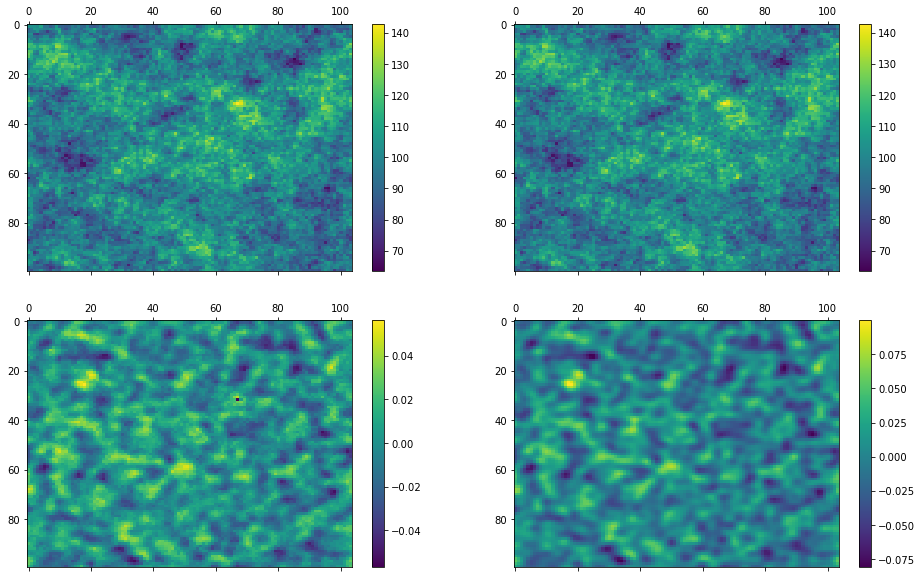

In [66]:
x_map = unpack_solution(x_soln, rfft_shape, sqrtS=sqrtS)

# Plot slices
plt.subplot(221)
plt.matshow(fg_amp, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(222)
plt.matshow(x_map, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(223)
plt.matshow(x_map - fg_amp, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(224)
plt.matshow(np.mean(s, axis=-1), aspect='auto', fignum=False)
plt.colorbar()

plt.gcf().set_size_inches((16., 10.))